In [1]:
###############################################
### TO RUN ON MICROSOFT PLANETARY COMPUTER ####
###############################################

### Preliminaries

In [53]:
import planetary_computer
import pystac_client

import numpy as np
import xarray as xr

# import cdsapi
from urllib.request import urlopen

import getpass
import azure.storage.blob
import zarr

In [61]:
######################
# Azure blob storage
######################
# connection string (from azure web login, select your storage account, then "Access keys")
connection_string = getpass.getpass()

    
# format storage
container_client = azure.storage.blob.ContainerClient.from_connection_string(
    connection_string, container_name="mpctransfer")

 ········


In [4]:
# Historical period = 1980 - 2014
years = [str(year) for year in range(1980, 2015)]
months = [str(mnth).zfill(2) for mnth in range(1, 13)]

make_datetime = lambda year, month: year + '-' + month

datetimes = [make_datetime(year, month) for year in years for month in months]

In [5]:
# catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)

In [54]:
#########
# Dask
#########
import dask_gateway
gateway = dask_gateway.Gateway()

# cluster options
cluster_options = gateway.cluster_options()
cluster_options["worker_memory"] = 20
cluster_options["worker_cores"] = 1

# start cluster
cluster = gateway.new_cluster(cluster_options)
client = cluster.get_client()
cluster.scale(20)

# dashboard link
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.ec0caac0133a4495be145cd3719a25a4/status


# Step 0: get land mask

In [5]:
###############################################
# Run this once and then restart the kernel,
# otherwise there are issues with MPC data
###############################################

In [1]:
%%bash
{
  echo 'url: https://cds.climate.copernicus.eu/api/v2'
  echo 'key: UID:API_KEY'
  echo 'verify: 0'
} > ~/.cdsapirc

In [2]:
%%bash 
{
  echo 'url: https://cds.climate.copernicus.eu/api/v2'
  echo 'key: 162352:4e0782ac-d924-4778-9ec9-096acd4dfb06'
  echo 'verify: 0'
} > ~/.cdsapirc

In [5]:
%%bash 
mamba install cdsapi

Transaction

  Prefix: /srv/conda/envs/notebook

  Updating specs:

   - cdsapi
   - ca-certificates
   - certifi
   - openssl


  Package              Version  Build         Channel                   Size
──────────────────────────────────────────────────────────────────────────────
  Install:
──────────────────────────────────────────────────────────────────────────────

  + cdsapi               0.5.1  pyhd8ed1ab_0  conda-forge/noarch        15kB

  Upgrade:
──────────────────────────────────────────────────────────────────────────────

  - ca-certificates  2022.9.14  ha878542_0    installed                     
  + ca-certificates  2022.9.24  ha878542_0    conda-forge/linux-64     154kB
  - certifi          2022.9.14  pyhd8ed1ab_0  installed                     
  + certifi          2022.9.24  pyhd8ed1ab_0  conda-forge/noarch       159kB
  - openssl             1.1.1q  h166bdaf_0    installed                     
  + openssl             1.1.1s  h166bdaf_0    conda-forge/linux-64    

In [6]:
# start the client
cds = cdsapi.Client() 
# dataset to read
dataset = "reanalysis-era5-single-levels" 
# flag to download data
params = {
    "product_type": "reanalysis",
    "variable": "land_binary_mask",
    "format": "netcdf",
    "grid": [0.25, 0.25],
    "area": [90, -180, -90, 180],
    'year': '1981',
    'month': '01',
    'day': '01',
    'time': '01:00'
    }
# retrieves the path to the file
fl = cds.retrieve(dataset, params)

# load into memory
with urlopen(fl.location) as f:
    ds_mask = xr.open_dataset(f.read())

/srv/conda/envs/notebook/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2022-11-07 16:06:14,739 INFO Welcome to the CDS
2022-11-07 16:06:14,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
/srv/conda/envs/notebook/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
2022-11-07 16:06:14,859 INFO Request is completed
2022-11-07 16:06:16,845 INFO Resource 'XMLSchema.xsd' is already loaded


In [7]:
# conservative land mask: fraction of sea = 0
ds_mask = ds_mask.rename({'latitude':'lat', 'longitude':'lon'})
ds_mask = ds_mask.isel(time=0).sel(lat = slice(90,-60))
ds_mask = ds_mask.lsm > 0

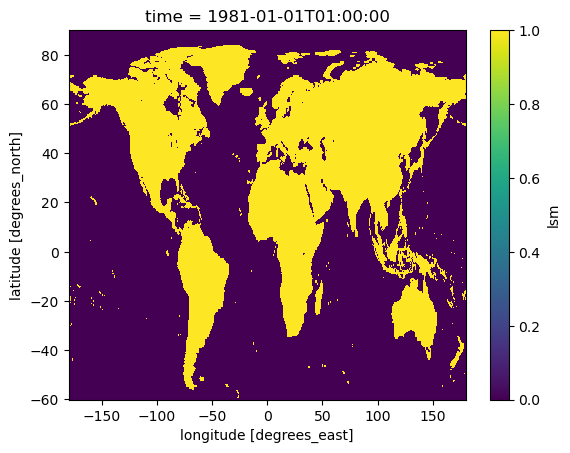

In [8]:
ds_mask.plot()

In [11]:
# store locally
ds_mask.to_netcdf('../data/era5_land_mask.nc')

# Step 1: hourly to daily

In [7]:
# read land mask
ds_mask = xr.open_dataset('../data/era5_land_mask.nc').lsm

## Temperature

In [8]:
%%time
# Final dataset
ds_final = []

# Loop through months
for datetime in datetimes:
    # Search
    search = catalog.search(collections=["era5-pds"], 
                            query={"era5:kind": {"eq": "an"}},
                            datetime=datetime)

    item = search.get_all_items()[0]
    signed_item = planetary_computer.sign(item)
    asset = signed_item.assets['air_temperature_at_2_metres']
    
    # Open file
    ds = xr.open_dataset(asset.href, **asset.extra_fields["xarray:open_kwargs"])
    
    # Update lon to match mask
    ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
    ds = ds.sortby('lon')
    
    # Land mask
    ds = ds.where(ds_mask)

    # Get tasavg, tasmax, tasmin
    ds_tmax = ds.resample(time='1D').max().rename({'air_temperature_at_2_metres':'tasmax'})
    ds_tmin = ds.resample(time='1D').min().rename({'air_temperature_at_2_metres':'tasmin'})
    ds_tas = ds.resample(time='1D').mean().rename({'air_temperature_at_2_metres':'tas'})

    # Combine
    ds = xr.combine_by_coords([ds_tas, ds_tmax, ds_tmin], join="exact")
    
    # Append
    ds_final.append(ds)

# Combine all
ds_final = xr.concat(ds_final, dim='time')

CPU times: user 1min, sys: 1.96 s, total: 1min 2s
Wall time: 2min 31s


In [9]:
%%time
# Write to azure storage
ds_final = ds_final.chunk({'time':365, 'lat':180, 'lon':360})
    
compressor = zarr.Blosc(cname='zstd', clevel=3)
encoding = {vname: {'compressor': compressor} for vname in ds_final.data_vars}
    
azure_prefix = 'era5/temperature'
store = zarr.ABSStore(client=container_client, prefix=azure_prefix)

# store
ds_final.to_zarr(store=store, encoding=encoding, consolidated=True, mode='w')

CPU times: user 3min 16s, sys: 8.82 s, total: 3min 25s
Wall time: 23min 26s


## Precipitation

In [13]:
%%time
# Final dataset
ds_final = []

# Loop through months
for datetime in datetimes:
    # Search
    search = catalog.search(collections=["era5-pds"], 
                            query={"era5:kind": {"eq": "fc"}},
                            datetime=datetime)

    item = search.get_all_items()[0]
    signed_item = planetary_computer.sign(item)
    asset = signed_item.assets['precipitation_amount_1hour_Accumulation']
    
    # Open file
    ds = xr.open_dataset(asset.href, **asset.extra_fields["xarray:open_kwargs"])
    
    # Update lon to match mask
    ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
    ds = ds.sortby('lon')
    
    # Land mask
    ds = ds.where(ds_mask)

    # Get tasavg, tasmax, tasmin
    ds_prcp = ds.resample(time='1D').sum().rename({'precipitation_amount_1hour_Accumulation':'pr'})
    
    # Append
    ds_final.append(ds_prcp)

# Combine all
ds_final = xr.concat(ds_final, dim='time')

CPU times: user 54.7 s, sys: 1.56 s, total: 56.2 s
Wall time: 5min 31s


In [16]:
%%time
# Write to azure storage
ds_final = ds_final.chunk({'time':365, 'lat':180, 'lon':360})
    
compressor = zarr.Blosc(cname='zstd', clevel=3)
encoding = {vname: {'compressor': compressor} for vname in ds_final.data_vars}
    
azure_prefix = 'era5/precip'
store = zarr.ABSStore(client=container_client, prefix=azure_prefix)

# store
ds_final.to_zarr(store=store, encoding=encoding, consolidated=True, mode='w')

CPU times: user 1min 44s, sys: 4.08 s, total: 1min 48s
Wall time: 8min 42s


# Step 2: quantiles

## Temperature

In [62]:
# Read from zarr
azure_prefix = 'era5/temperature'
store = zarr.ABSStore(client=container_client, prefix=azure_prefix)

# store
ds = xr.open_zarr(store=store)

In [63]:
%%time
# rechunk for quantile calculations
ds = ds.chunk({'time':-1, 'lat':50, 'lon':50})

# Get 99.95th, 99.97th, 99.99th quantiles
ds_rp5 = ds.quantile(q=0.9995, dim='time').compute() # approx 1-in-5 year event
ds_rp10 = ds.quantile(q=0.9997, dim='time').compute() # approx 1-in-10 year event
ds_rp20 = ds.quantile(q=0.9999, dim='time').compute() # approx 1-in-20 year event

CPU times: user 19.8 s, sys: 652 ms, total: 20.4 s
Wall time: 4min 45s


In [64]:
# Merge and store
ds_out = xr.merge([ds_rp5.drop('quantile').rename({'tas':'tas_rp5',
                                                   'tasmax':'tasmax_rp5',
                                                   'tasmin':'tasmin_rp5'}),
                   ds_rp10.drop('quantile').rename({'tas':'tas_rp10',
                                                   'tasmax':'tasmax_rp10',
                                                   'tasmin':'tasmin_rp10'}),
                   ds_rp20.drop('quantile').rename({'tas':'tas_rp20',
                                                   'tasmax':'tasmax_rp20',
                                                   'tasmin':'tasmin_rp20'})])

ds_out -= 273.15 # K -> C
ds_out.to_netcdf('../data/era5_temperature_quantiles.nc')

## Precipitation

In [65]:
# Read from zarr
azure_prefix = 'era5/precip'
store = zarr.ABSStore(client=container_client, prefix=azure_prefix)

# store
ds = xr.open_zarr(store=store)

In [66]:
%%time
# rechunk for quantile calculations
ds = ds.chunk({'time':-1, 'lat':50, 'lon':50})

# Get 99.95th, 99.97th, 99.99th quantiles (wet days only: >1mm)
ds_rp5 = ds.where(ds.pr > 0.001).quantile(q=0.9995, dim='time').compute() # approx 1-in-5 year event
ds_rp10 = ds.where(ds.pr > 0.001).quantile(q=0.9997, dim='time').compute() # approx 1-in-10 year event
ds_rp20 = ds.where(ds.pr > 0.001).quantile(q=0.9999, dim='time').compute() # approx 1-in-20 year event

CPU times: user 6.72 s, sys: 130 ms, total: 6.85 s
Wall time: 1min 44s


In [67]:
# Merge and store
ds_out = xr.merge([ds_rp5.drop('quantile').rename({'pr':'pr_rp5'}),
                   ds_rp10.drop('quantile').rename({'pr':'pr_rp10'}),
                   ds_rp20.drop('quantile').rename({'pr':'pr_rp20'})])

ds_out *= 1000 # m -> mm
ds_out.to_netcdf('../data/era5_precip_quantiles.nc')